## Connection to Thymio

In [1]:
# Connect to Thymio with ClientAsync
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()

# Lock Thymio
aw(node.lock())

Node 52ceb7f5-6164-4bf6-b28a-33899f775678

## Importation of libraries

In [2]:
import keyboard
import time
from kalman_filtering.kalman_filter import *
from thymio.control import *
from computer_vision.vision import *
from path_planning.path_plan import *
from navigation.collision_avoidance import * 

await node.set_variables(motors(0, 0))

## Main script

In [ ]:
map = Map()
if P_VISION:
    print(P_SETUP)
    print("Place the Thymio and the destination, check the avoidance_modes and the corners. Then, press S.")

# Create windows with first update
map.update(True) 

while True:
    
    if keyboard.is_pressed('space'):
        map.update(True)
    
    if keyboard.is_pressed('s'):
        if map.found_corners and map.found_destination:
            map.update()
            break
        else:
            print("USER: Must find corners before start")
    
    cv.waitKey(10)

if P_VISION: print(P_START)
if P_VISION: map.info()
await node.wait_for_variables()

vel_old = np.zeros(2)
mu_est_old = map.robot
cov_est_old = 100*np.eye(3)
view_blocked = False
active = True
end = False
start = True
path = None
segment_index = 0
avoidance_mode = 0
obj_right = False
obstacle_pos = np.array([0, 0])
destination = map.destination[0:2]
pos_robot = map.robot[0:2]
dt = 0.12

while active == True:
    start_time = time.time()
    #print("----------------------")
    active = await stop_thymio(node)

    map.update()
    
    # State variables measurement
    await node.wait_for_variables()
 
    # Filtering
    y = map.robot
    x_est, cov_est = kalman_filter(y, vel_old, mu_est_old, cov_est_old, map.found_robot, dt)
    map.pose_est = np.array([int(x_est[0]), int(x_est[1]), x_est[2]], dtype=object)
    #print("Estimated pose of Thymio:", map.pose_est)
    #print("Real pose of Thymio:", map.robot)
    cov_predict_old = cov_est
    mu_est_old = map.pose_est
   
    # Check if final destination moved
    change_dest = ((map.destination[1]-destination[1])**2 + (map.destination[0]-destination[0])**2)*0.5
    if change_dest > 20:
        start = True
        print("Nouveau chemin destination changé")

    #  Check if the robot has been relocated
    change_robot = ((map.pose_est[1]-pos_robot[1])**2 + (map.pose_est[0]-pos_robot[0])**2)*0.5
    if change_robot > 200:
        start = True
        print("Nouveau chemin robot changé")
   
    # Global Navigation
    if start == True:
        destination = map.destination[0:2]
        ex_path, corners = compute_visibility_matrix(map.pose_est[0:2], destination, map.obstacles)
        map.obstacles_lines = possible_lignes(ex_path, corners)
        map.target_lines = a_star_search(corners, ex_path)
        path = path_functions(map.target_lines)
        segment_index = 0
        start = False

    #local nav
    u, avoidance_mode, segment_index, obj_right, obstacle_pos = await collision_avoidance(path, node, map.pose_est, avoidance_mode, segment_index, obj_right, obstacle_pos, map.destination[0:2]) # Zacharie
    #print("avoidance_mode", avoidance_mode)

    if not avoidance_mode:
        u, segment_index, end = path_direction(map.pose_est, path, segment_index)
    
    #update robot position            
    pos_robot = map.pose_est[0:2]

    await node.set_variables(motors(int(u[0]), int(u[1])))

    vel_old = u
    
    end_time = time.time()
    # Update execution time
    dt = end_time - start_time
    #print("Execution time:", dt)  
    cv.waitKey(10)
    if keyboard.is_pressed('q'):
        map.__del__()
        break

## Thymio velocity measurements

Center button pressed. Stopping the algorithm.
Left vel measured: [89, 89, 98, 98, 109, 109, 109, 101, 101, 101, 100, 100, 97, 97, 97, 107, 107, 94, 94, 108, 108, 108, 122, 122, 92, 92, 92, 95, 97, 97, 97, 93, 93, 90, 90, 90, 98, 98, 87, 87, 112, 112, 112, 103, 103, 94, 94, 94, 91, 91, 96, 96, 96, 96, 96, 96, 90, 90, 87, 87, 87, 103, 103, 102, 102, 102, 94, 94, 94, 93, 96, 96, 103, 103, 108, 108, 108, 89, 89, 94, 94, 92, 92, 92, 114, 114, 104, 104, 103, 103, 104, 104, 104, 100, 100, 95, 95, 95, 95, 95, 94, 94, 94, 94, 92, 92, 93, 93, 102, 102, 89, 89, 96, 96, 96, 86, 86, 123, 123, 123, 91, 91, 95, 95, 86, 86, 98, 98, 89, 89, 89, 98, 98, 98, 102, 102, 96, 96, 101, 101, 101, 111, 111, 96, 96, 97, 97, 91, 91, 96, 96, 96, 99, 99, 109, 109, 109, 98, 98, 113, 113, 94, 94, 94, 91, 91, 94, 94, 83, 83, 83, 97, 97, 91, 91, 91, 91, 92, 92, 92, 92, 92, 88, 88, 109, 109, 109, 104, 104, 100, 100, 98, 98, 98, 106, 106, 106, 93, 93, 105, 105, 104, 104, 104, 89, 89, 86, 86, 97, 97, 98, 98, 98, 98, 90, 

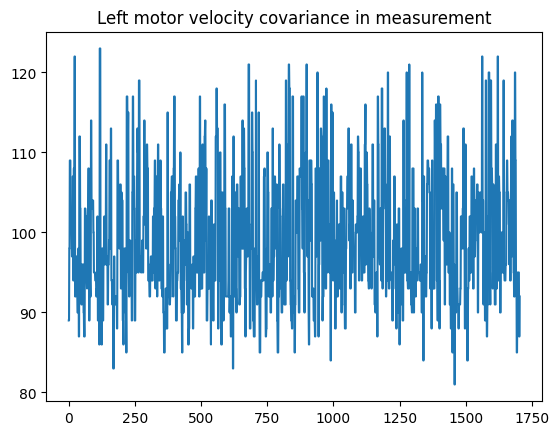

Right vel measured: [94, 94, 98, 98, 101, 101, 101, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 99, 99, 99, 126, 126, 111, 111, 111, 98, 99, 99, 99, 125, 125, 99, 99, 99, 94, 94, 97, 97, 98, 98, 98, 96, 96, 95, 95, 95, 100, 100, 113, 113, 113, 104, 104, 104, 98, 98, 97, 97, 97, 108, 108, 95, 95, 95, 98, 98, 98, 95, 94, 94, 110, 110, 112, 112, 112, 114, 114, 104, 104, 100, 100, 100, 90, 90, 97, 97, 102, 102, 98, 98, 98, 95, 95, 98, 93, 93, 93, 93, 94, 98, 98, 98, 100, 100, 93, 93, 97, 97, 95, 95, 97, 97, 97, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 97, 97, 93, 93, 93, 94, 94, 94, 112, 112, 113, 113, 98, 98, 98, 102, 102, 102, 102, 103, 103, 100, 100, 98, 98, 98, 92, 92, 95, 95, 95, 96, 96, 95, 95, 104, 104, 104, 103, 103, 99, 99, 91, 91, 91, 98, 98, 97, 97, 97, 97, 98, 98, 103, 103, 103, 98, 98, 97, 97, 97, 99, 99, 99, 99, 93, 93, 93, 91, 91, 91, 105, 105, 106, 106, 97, 97, 97, 108, 108, 96, 96, 101, 101, 96, 96, 84, 84, 95, 95, 95, 95, 95, 102, 102, 102, 100, 100, 100, 100, 12

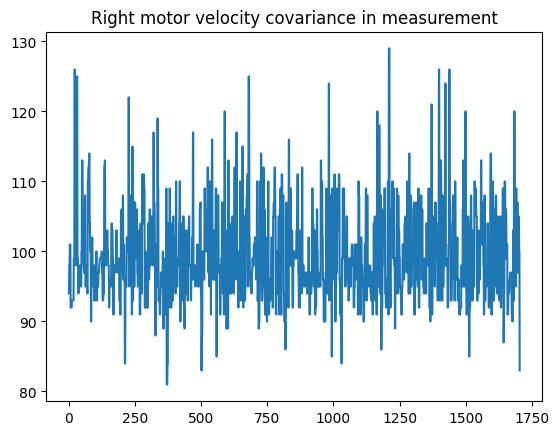

In [ ]:
from thymio.control import *
import matplotlib.pyplot as plt

active = True
v_l = []
v_r = []

while active:
    await node.wait_for_variables()
    await node.set_variables(motors(100, 100))
    v = get_thymio_velocity(node)
    v_l.append(v[0])
    v_r.append(v[1])
    active = await stop_thymio(node)

await node.set_variables(motors(0, 0)) 

v_l_mean = np.mean(v_l[10:])
v_l_var = np.var(v_l[10:])

v_r_mean = np.mean(v_r[10:])
v_r_var = np.var(v_r[10:])

print("Left vel measured:", v_l[10:])
print("Left vel mean:", v_l_mean)
print("Left vel variance:", v_l_var)

nb_iteration = np.linspace(0, len(v_l[10:]), len(v_l[10:]))
plt.plot(nb_iteration, v_l[10:])
plt.title("Left motor velocity covariance in measurement")
plt.show()

print("Right vel measured:", v_r[10:])
print("Right vel mean:", v_r_mean)
print("Right vel variance:", v_r_var)

nb_iteration = np.linspace(0, len(v_r[10:]), len(v_r[10:]))
plt.plot(nb_iteration, v_r[10:])
plt.title("Right motor velocity covariance in measurement")
plt.show()

## Thymio position measurements

In [ ]:
import matplotlib.pyplot as plt

map = Map()

robot_positions_x = []
robot_positions_y = []
robot_positions_theta = []
map.update(True)
while True:
    start = time.time()
    map.update()
    robot_position_x = map.robot[0]
    robot_positions_x.append(robot_position_x)

    robot_position_y = map.robot[1]
    robot_positions_y.append(robot_position_y)
    
    robot_position_theta = map.robot[2] 
    robot_positions_theta.append(robot_position_theta)
    end = time.time()
    dt = end - start
    print(dt)

    if cv.waitKey(20) & 0xFF==ord("d"):
        map.__del__()
        break

robot_positions_x_mean = np.mean(robot_positions_x[10:])
robot_positions_x_var = np.var(robot_positions_x[10:])

robot_positions_y_mean = np.mean(robot_positions_y[10:])
robot_positions_y_var = np.var(robot_positions_y[10:])

robot_positions_theta_mean = np.mean(robot_positions_theta[10:])
robot_positions_theta_var = np.var(robot_positions_theta[10:])

print("Position x measured:", robot_positions_x[10:])
print("Position x mean:", robot_positions_x_mean)
print("Position x variance:", robot_positions_x_var)

nb_iteration = np.linspace(0, len(robot_positions_x[10:]), len(robot_positions_x[10:]))
plt.plot(nb_iteration, robot_positions_x[10:])
plt.title("Position x covariance in measurement")
plt.show()

print("Position y measured:", robot_positions_y[10:])
print("Position y mean:", robot_positions_y_mean)
print("Position y variance:", robot_positions_y_var)

plt.plot(nb_iteration, robot_positions_y[10:])
plt.title("Position y covariance in measurement")
plt.show()

print("Position theta measured:", robot_positions_theta[10:])
print("Position theta mean:", robot_positions_theta_mean)
print("Position theta variance:", robot_positions_theta_var)

plt.plot(nb_iteration, robot_positions_theta[10:])
plt.title("Position theta covariance in measurement")
plt.show()

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable cos method

In [ ]:
node.var

{'_fwversion': [14, 0],
 '_id': [-27410],
 '_imot': [-162, -184],
 '_integrator': [-1079, -1177],
 '_productId': [8],
 '_vbat': [690, 688],
 'acc': [3, 0, 21],
 'acc._tap': [32],
 'button.backward': [0],
 'button.center': [1],
 'button.forward': [0],
 'button.left': [0],
 'button.right': [0],
 'buttons._mean': [10674, 9159, 13755, 13702, 15106],
 'buttons._noise': [58, 40, 62, 60, 57],
 'buttons._raw': [10658, 9157, 12878, 13710, 15109],
 'event.args': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'event.source': [-27410],
 'leds.bottom.left': [0, 0, 0],
 'leds.bottom.right': [0, 0, 0],
 'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
 'leds.top': [0, 0, 0],
 'mic._mean': [283],
 'mic.intensity': [65],
 'mic.threshold': [0],
 'motor.left.pwm': [-421],
 'motor.left.speed': [89],
 'motor.left.target': [100],
 'motor.right.pwm': [-438],
 'motor.right.speed': [82],
 'motor.right.targ